# (1) 查看 VGG16 架構

In [1]:
#載入 VGG16 架構
from keras import applications
vgg_model = applications.VGG16(weights='imagenet', include_top=True)#it is input shape (224,224,3)

#定義輸入端與應用
from keras.layers import Input
input_tensor = Input(shape=(160, 160, 3))
vgg_model = applications.VGG16(weights='imagenet',include_top=False,input_tensor=input_tensor)

#查看架構
vgg_model.summary()

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_____________________________________________

# (2) 進行 Keras 遷移學習

### 下載模組與資料庫

In [2]:
#loading database
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam


#loadding Model
mobile = keras.applications.mobilenet.MobileNet()

#Loading and Prepare Image
def prepare_image(path_file):
    img = image.load_img(path_file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

#預測
#Image(filename=r'E:\OneDrive - 大聯大投資控股股份有限公司\ATU 重要文件\ATU 績效評比\MPU_QPI_Weilly_Li_20201220\Keras 遷移學習\German_Shepherd.jpg')
preprocessed_image = prepare_image(r'downloads\German_Shepherd.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
print('test 1 _ German_shepherd  = \n',results) #German_shepherd is correct
print('\n')

preprocessed_image = prepare_image(r'downloads\blue_tit.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
print('test 2 _ Blue tit  = \n',results) #German_shepherd isnt correct


Using TensorFlow backend.


test 1 _ German_shepherd  = 
 [[('n02106662', 'German_shepherd', 0.99202275), ('n02105162', 'malinois', 0.0077901813), ('n02091467', 'Norwegian_elkhound', 0.000110999914), ('n02116738', 'African_hunting_dog', 3.3588236e-05), ('n02105412', 'kelpie', 2.3689094e-05)]]


test 2 _ Blue tit  = 
 [[('n01592084', 'chickadee', 0.98511803), ('n01530575', 'brambling', 0.0059011523), ('n01828970', 'bee_eater', 0.0043943315), ('n01532829', 'house_finch', 0.0025512946), ('n01824575', 'coucal', 0.00061693124)]]


![title](GoogleImagesDownload.png)

In [17]:
#下載新的樣本與標籤，用於遷移學習
#https://github.com/hardikvasa/google-images-download
!pip install google_images_download
from google_images_download import google_images_download
response = google_images_download.googleimagesdownload()
arguments = {"keywords":"blue tit","limit":100,"print_urls":True,"format":"jpg", "size":">400*300", "chromedriver" : r"C:\Program Files (x86)\Google\Chrome\Application\chromedriver.exe"}
paths = response.download(arguments)#下載藍雀的圖片
arguments = {"keywords":"crow","limit":100,"print_urls":True, "format":"jpg", "size":">400*300"}
paths = response.download(arguments)#下載烏鴉的圖片


Item no.: 1 --> Item name = blue tit
Evaluating...
Starting Download...


Unfortunately all 20 could not be downloaded because some images were not downloadable. 0 is all we got for this search filter!

Errors: 0



### 修改神經網路架構

In [18]:
import sys
import os
#https://github.com/ultralytics/google-images-download
!python bing_scraper.py --search 'bluetit' --limit 100 --size >400*300 --download --chromedriver D:\Python\chromedriver.exe
!python bing_scraper.py --search 'crow' --limit 100 --download --chromedriver D:\Python\chromedriver.exe

python: can't open file 'bing_scraper.py': [Errno 2] No such file or directory


In [3]:
#下載以訓練好的 MobileNet，進行遷移學習之修改模型
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
base_model.summary()
#修改最後頂部幾層
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation,Dense two class
model = Model(inputs=base_model.input, outputs=preds)# 构建我们需要训练的完整模型

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

### 確認新架構，並進行訓練

In [10]:
#查看模型架構
#for i,layer in enumerate(base_model.layers):
#    print(i,layer.name)
   
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [4]:
#進行遷移學習訓練 MobileNet，
#前20層(細節特徵，線、顏色、圓形、尾巴、眼睛)等，不進行再次訓練
#20層後(物件特徵，貓、狗)等，進行再次訓練
for layer in model.layers:
    layer.trainable=False
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

#設定訓練目標
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
train_generator=train_datagen.flow_from_directory(r'D:\Python\Tensorflow\TF_Keras_MobileNet\downloads',target_size=(224,224),color_mode='rgb',batch_size=2,class_mode='categorical',shuffle=True)#加入訓練資料

#設定最佳化
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

#開始訓練
step_size_train=train_generator.n//train_generator.batch_size
H = model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,epochs=10)
#https://zhuanlan.zhihu.com/p/50424450

Found 164 images belonging to 2 classes.
Epoch 1/10
82/82 [==============================] - 26s 322ms/step - loss: 0.8161 - accuracy: 0.6402
Epoch 2/10
82/82 [==============================] - 24s 290ms/step - loss: 0.7185 - accuracy: 0.7134
Epoch 3/10
82/82 [==============================] - 22s 273ms/step - loss: 0.5848 - accuracy: 0.7073
Epoch 4/10
82/82 [==============================] - 22s 274ms/step - loss: 0.4442 - accuracy: 0.7988
Epoch 5/10
82/82 [==============================] - 23s 277ms/step - loss: 0.3710 - accuracy: 0.8902
Epoch 6/10
82/82 [==============================] - 23s 279ms/step - loss: 0.3271 - accuracy: 0.8720
Epoch 7/10
82/82 [==============================] - 23s 280ms/step - loss: 0.4005 - accuracy: 0.8598
Epoch 8/10
82/82 [==============================] - 23s 276ms/step - loss: 0.5411 - accuracy: 0.7622
Epoch 9/10
82/82 [==============================] - 23s 276ms/step - loss: 0.3905 - accuracy: 0.8780
Epoch 10/10
82/82 [==============================]

### 檢視準確度

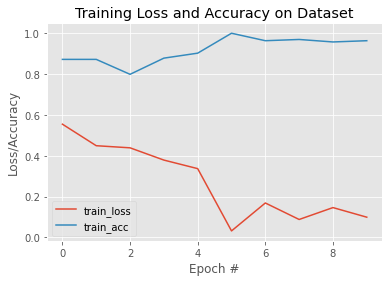

In [12]:
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #");plt.ylabel("Loss/Accuracy");plt.legend(loc="lower left")

# (3) 使用新架構並查看結果

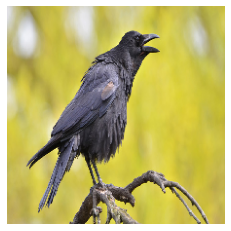

array([[7.433351e-04, 9.992567e-01]], dtype=float32)

In [55]:
from matplotlib import pyplot as plt
def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
    
    return img_tensor
 
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = r'D:\Python\Tensorflow\TF_Keras_MobileNet\downloads\crow\31.Black-crow-Corvus-corone-common-crow-shut.jpg'
new_image = load_image(img_path, show=True)
pred = model.predict(new_image)#[blue-tit,crow]

pred

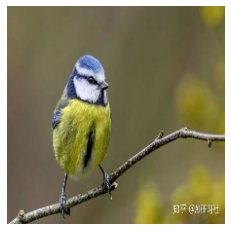

array([[0.9935939 , 0.00640611]], dtype=float32)

In [7]:
from matplotlib import pyplot as plt
def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
    
    return img_tensor
 
img_path = r'downloads\blue_tit.jpg'
new_image = load_image(img_path, show=True)
pred = model.predict(new_image)#[blue-tit,crow]
pred